In [12]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import Room, Object, Region
from Region import * 

api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)

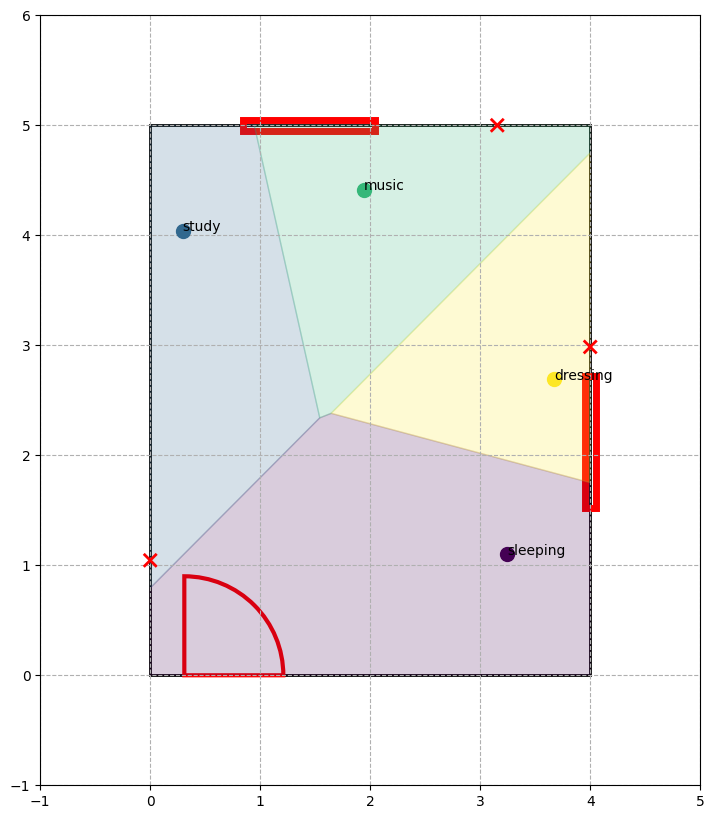

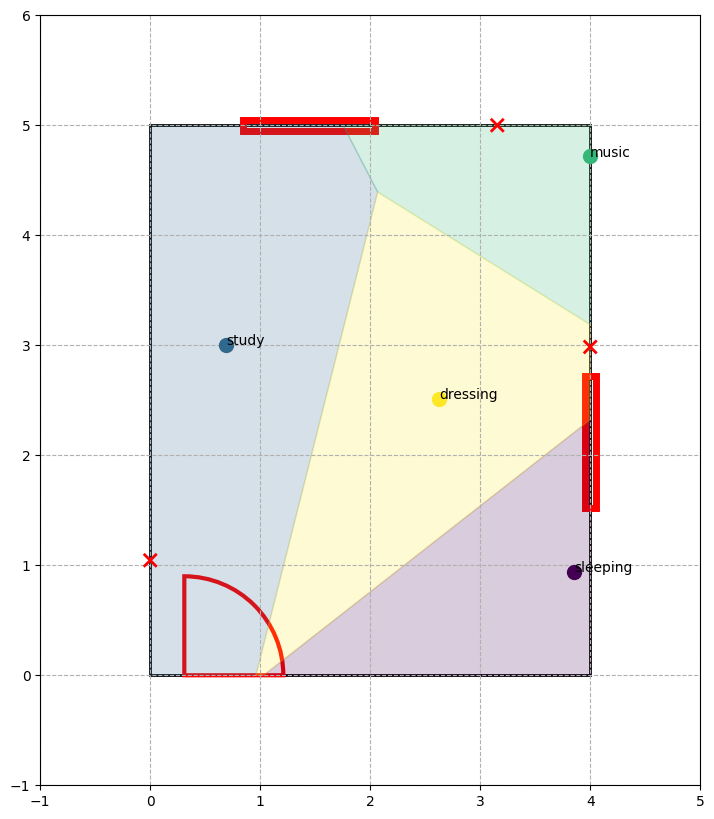

In [38]:
scene_descriptor = "a bedroom for a teenage girl who plays the guitar."

# initialise the room
bedroom = create_room(4, 5)

# create the fixed objects
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'north', position = 0.3)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'east', position = 0.4)
create_fixed_object(bedroom, 'door', 0.9, 0.1, 'south', position = 0.1)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'west', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'north', position = 0.8)
create_fixed_object(bedroom, 'socket', 0.15, 0.1, 'east', position = 0.6)

# initialise the regions
sleeping_region = region_setup(bedroom, 'sleeping', 0)
study_region = region_setup(bedroom, 'study', 1)
music_region = region_setup(bedroom, 'music', 2)
dressing_region = region_setup(bedroom, 'dressing', 3)

# draw the room
bedroom.draw(draw_regions = True)

positions = np.zeros(2*len(bedroom.regions)) 
for i in range(len(bedroom.regions)): 
    positions[2*(bedroom.regions[i].index)] = bedroom.regions[i].x
    positions[2*(bedroom.regions[i].index) + 1] = bedroom.regions[i].y

def optimize_regions(positions, bedroom): 
    output = 0
    output += close_to_fixed_object(positions, bedroom, 'sleeping', 'socket')
    output += away_from_fixed_object(positions, bedroom, 'sleeping', 'window')
    output += close_to_wall(positions, bedroom, 'sleeping')
    output += close_to_fixed_object(positions, bedroom, 'study', 'window')
    output += close_to_fixed_object(positions, bedroom, 'study', 'socket')
    output += away_from(positions, bedroom, 'study', 'music')
    output += close_to_fixed_object(positions, bedroom, 'music', 'socket')
    output += away_from(positions, bedroom, 'music', 'sleeping')
    output += close_to_fixed_object(positions, bedroom, 'dressing', 'window')
    output += close_to(positions, bedroom, 'dressing', 'sleeping')
    output += close_to(positions, bedroom, 'study', 'dressing')
    output += include_focal_point(positions, bedroom, 'music')
    output += distinct_regions(positions, bedroom)
    return output

bounds = Bounds([0] * 2 * len(bedroom.regions), [bedroom.width, bedroom.length] * len(bedroom.regions)) 
res = minimize(optimize_regions, positions, args = (bedroom), method = 'Nelder-Mead', bounds=bounds) 
for i in range(len(bedroom.regions)): 
    bedroom.regions[i].x, bedroom.regions[i].y = res.x[2*(bedroom.regions[i].index):2*(bedroom.regions[i].index) + 2] 
bedroom.draw(draw_regions = True)

In [26]:
fixed_objects = ""
for i in range(len(bedroom.fixed_objects)):
    if i < len(bedroom.fixed_objects) - 1:
        fixed_objects += bedroom.fixed_objects[i].name + ", "
    else: 
        fixed_objects += bedroom.fixed_objects[i].name + "."
print(fixed_objects)
bedroom_width = bedroom.width
bedroom_length = bedroom.length

region_names = ""
for i in range(len(bedroom.regions)):
    if i < len(bedroom.regions) - 1:
        region_names += bedroom.regions[i].name + ", "
    else: 
        region_names += bedroom.regions[i].name + "."
print(region_names)

window, window, door, socket, socket, socket.
sleeping, study, music, dressing.


In [25]:
prompt7 = "I am going to give you a description of a room, as well as all the fixed objects inside it (e.g. windows) and the dimensions of the room."
prompt7 += " I am also going to give you the different regions for the room. Based on this information, I want returned the most important object for each region,"
prompt7 += " and the dimensions for that object in meters. This should include width and length, not height. The room description is: "
prompt7 += scene_descriptor + ", and the regions are: " + regions + ". The fixed objects are: " + fixed_objects
prompt7 += " Finally, the room dimensions are, width : " + str(bedroom_width) + " meters, and length : " + str(bedroom_length) + " meters."
prompt7 += "Please return it in the format of {object_name: name, object_width: width, object_length: length, region: region_name}. After the list, I also want you to give me all the constraints for each object"
prompt7 += " that depend on the items in the room. For example if an object should be against a wall, far away from a window, or near a socket. Give these as simply as possible, in the following format:  "
prompt7 += "{object_name: name, constraints: [constraint1, constraint2, ...]}. Give no other text in the response."

response7 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt7}],
        max_tokens=500
    )

print(response7.choices[0].message.content)

prompt8 = "Given this list of the objects: " + response7.choices[0].message.content[0] + ", use the file attached (as well as the room code so far) to add the objects into the room with the correct parameters."
print(prompt8)  

[
    {object_name: bed, object_width: 1.4, object_length: 2, region: sleeping region},
    {object_name: desk, object_width: 1, object_length: 0.6, region: study region},
    {object_name: guitar stand, object_width: 0.5, object_length: 0.5, region: music region},
    {object_name: wardrobe, object_width: 1.2, object_length: 0.6, region: dressing region}
]

[
    {object_name: bed, constraints: [against a wall, far from window]},
    {object_name: desk, constraints: [near a socket, near window]},
    {object_name: guitar stand, constraints: [near a socket, away from door]},
    {object_name: wardrobe, constraints: [against a wall, away from windows]}
]


In [31]:

prompt8 = "Given this list of the objects: " + response7.choices[0].message.content.split("]")[0] + "], use the file attached (as well as the room code so far) to add the objects into the room with the correct parameters."
prompt8 += "The room code so far is: " + 
print(prompt8)  

Given this list of the objects: [
    {object_name: bed, object_width: 1.4, object_length: 2, region: sleeping region},
    {object_name: desk, object_width: 1, object_length: 0.6, region: study region},
    {object_name: guitar stand, object_width: 0.5, object_length: 0.5, region: music region},
    {object_name: wardrobe, object_width: 1.2, object_length: 0.6, region: dressing region}
], use the file attached (as well as the room code so far) to add the objects into the room with the correct parameters.
